# Pre-process the data for the arrival/departure curve method

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import timeit

start_time = timeit.default_timer()
path = '/Volumes/GoogleDrive/My Drive/!STRIDE_Signal_Data_Fusion/Data/UDOT_Big_Data_Challenge/Data/Signal/Event data/7181/7181/7181_SB_20181106_Yend_offset.csv'
df = pd.read_csv(path)
df = df[['ID','Datetime','Event_code', 'Event_parameter', 'datetime_offset_format','hr','Cycle']]

def preprocess_data_for_arrival_departure_method():
    # Identify arrivals and departures and create separate dataframes for them
    df_a = df.where((df['Event_code']==82) & (df['Event_parameter']==4)).dropna()

    df_d = df.where(((df['Event_code']==82) & (df['Event_parameter']==41)) 
                      | ((df['Event_code']==82) & (df['Event_parameter']==42))
                      | ((df['Event_code']==82) & (df['Event_parameter']==43))).dropna()

    df_tm = df.where(((df['Event_code']==82) & (df['Event_parameter']==35)) 
                      | ((df['Event_code']==82) & (df['Event_parameter']==39))).dropna()

    # Get the number of arrivals and departures for each cycle
    df_a_count = df_a.groupby('Cycle').count() 
    df_a_count['A_count'] = df_a_count['ID'] 
    df_a_count = df_a_count[['A_count']]

    df_d_count = df_d.groupby('Cycle').count()
    df_d_count['D_count'] = df_d_count['ID']
    df_d_count = df_d_count[['D_count']]

    df_tm_count = df_tm.groupby('Cycle').count()
    df_tm_count['tm_count'] = df_tm_count['ID']
    df_tm_count = df_tm_count[['tm_count']]

    # Merge the dataframes
    df_a_d = pd.merge(df_a_count, df_d_count, how ='inner', on='Cycle')

    df_a_d['A_D_Diff'] = df_a_d['A_count']-df_a_d['D_count']

    # Separate cycles with more arrivals than departures (df_more_A), less arrivals than departures (df_less_A) 
    # and equal arrivals and departures (df_equal_AD).
    df_more_A = df_a_d.where(df_a_d['A_D_Diff']>0).dropna()
    df_less_A = df_a_d.where(df_a_d['A_D_Diff']<0).dropna()
    df_equal_AD = df_a_d.where(df_a_d['A_D_Diff']==0).dropna()

    # Create list of cycle and difference between arrivals and departures for each dataframe
    c_more = list((df_more_A.index).astype(int))
    c_more_toadj = list((df_more_A['D_count']).astype(int))

    c_less = list((df_less_A.index).astype(int))
    c_less_toadj = list(abs((df_less_A['A_D_Diff'])).astype(int))

    c_equal = list((df_equal_AD.index).astype(int))
    diff_equal = list(df_equal_AD)

    # Create empty df
    df_more_adj = df[:1]
    df_equal = df[:1]
    df_less = df[:1]

    # Remove the extra arrivals
    for x,y in zip(c_more,c_more_toadj):
        df_more_adj = df_more_adj.append(df_a.where(df_a['Cycle']==x).dropna().sample(n=y)) 
    df_more_adj = df_more_adj[1:] # drop the first row that was used to create the empty dataframe

    # Get arrivals for cycles that have equal number of arrivals and departures
    for x in c_equal:
        df_equal = df_equal.append(df_a.where(df_a['Cycle']==x).dropna())
    df_equal = df_equal[1:]

    # Get arrivals for cycles that have less number of arrivals than departures - missing are generated later on
    for x in c_less:
        df_less = df_less.append(df_a.where(df_a['Cycle']==x).dropna())
    df_less = df_less[1:]

    # Get the start and end of each cycle
    df_C_s = df.drop_duplicates('Cycle', keep='first')
    df_C_e = df.drop_duplicates('Cycle', keep='last')
    df_C = pd.merge(df_C_s,df_C_e, on = 'Cycle', how='inner')

    df_C= df_C[['Cycle','Datetime_x', 'Datetime_y']]
    df_C['C_S']=pd.to_datetime(df_C['Datetime_x'])#.dt.time
    df_C['C_S_Sec'] = ((df_C['C_S'].dt.hour)*3600)+((df_C['C_S'].dt.minute)*60) + ((df_C['C_S'].dt.second))
    df_C['C_E']=pd.to_datetime(df_C['Datetime_y'])#.dt.time
    df_C['C_E_Sec'] = ((df_C['C_E'].dt.hour)*3600)+((df_C['C_E'].dt.minute)*60) + ((df_C['C_E'].dt.second))
    df_C['diff'] = (df_C['C_E'])-(df_C['C_S'])
    df_C['diff_sec'] = df_C['diff'].dt.total_seconds()
    df_C = df_C[['Cycle','C_S','C_E','C_S_Sec','C_E_Sec', 'diff', 'diff_sec']]


    df_less_A['Cycle']= df_less_A.index.astype(int)
    df_C_less_A = pd.merge(df_C,df_less_A, on='Cycle',how='inner')
    df_C_less_A ['A_D_Diff_abs'] = (df_C_less_A['A_D_Diff']).abs().astype(int)


    #repeat rows as many time as the diff between arrivals and dep
    df_C_less_A = df_C_less_A.loc[df_C_less_A.index.repeat(df_C_less_A['A_D_Diff_abs'])]

    # Randomly generate timestamps between the start and end of cycles
    df_C_less_A['gen_DT'] = df_C_less_A.apply(lambda x : np.random.randint(x['C_S_Sec'],x['C_E_Sec'],1),axis=1)
    df_C_less_A['DT_gen'] = df_C_less_A['gen_DT'].astype(int)

    # Create the df_less_toadd dataframe


    # Convert seconds to time (hh:mm:sec)
    df_C_less_A['Time'] = df_C_less_A.apply(lambda x : str(datetime.timedelta(seconds=x['DT_gen'])),axis=1)


    df_C_less_A['Dates'] = '2018-11-06' # Add date column
    df_C_less_A['Datetime'] = df_C_less_A['Dates'] + ' ' + df_C_less_A['Time'] # concat date & time to make timestamp
    df_C_less_A['Datetime'] = pd.to_datetime(df_C_less_A.Datetime) # convert the column to timestamp
    df_C_less_A['hr'] = df_C_less_A.apply(lambda x: x['Datetime'].hour, 1) # get the hour from tstamp
    df_C_less_A['ID'] = 7181 # Add ID column
    df_C_less_A['Event_code'] = 82 # Add Event_code column
    df_C_less_A['Event_parameter'] = 4 # Add Event_parameter column
    df_C_less_A['datetime_format'] = df_C_less_A['Datetime'] # Add datetime_format column

    # create the missing timestamp df to be added to the total df
    df_less_toadd = df_C_less_A [['ID','Datetime','Event_code', 'Event_parameter', 'datetime_format', 'hr', 'Cycle']]

    # Combine all adjusted dataframes with the non-adjusted one (equal)

    # Organize the dataframes such that all of them have the same order of columns
    df_more_adj = df_more_adj [['ID','Datetime','Event_code', 'Event_parameter', 'hr', 'Cycle']]
    df_less_toadd = df_less_toadd [['ID','Datetime','Event_code', 'Event_parameter',  'hr', 'Cycle']]
    df_less = df_less [['ID','Datetime','Event_code', 'Event_parameter',  'hr', 'Cycle']]
    df_equal = df_equal [['ID','Datetime','Event_code', 'Event_parameter',  'hr', 'Cycle']]


    # concatenate the arrival dataframes 
    df_adjusted_arvls = (pd.concat([df_equal,df_less,df_less_toadd, df_more_adj]).sort_values('Cycle'))

    # concatenate the arrival df to departure df
    df_adjusted647 = pd.concat([df_adjusted_arvls, df_d])

    # Add sec from midnight to the dataframe
    df_adjusted647['Datetime'] = pd.to_datetime(df_adjusted647['Datetime'])
    df_adjusted647['Date'] = '2018-11-06'
    df_adjusted647['Date'] = pd.to_datetime(df_adjusted647['Date'])
    df_adjusted647['diff'] = df_adjusted647['Datetime']- df_adjusted647['Date']
    df_adjusted647['Sec'] = df_adjusted647['diff'].dt.total_seconds()

    # get rid of the unecessary columns
    df_adjusted647 = df_adjusted647 [['ID','Datetime','Event_code', 'Event_parameter', 'hr', 'Cycle','Sec']]
    df1 = df_adjusted647.sort_values('Sec')
    return df1

df1 = preprocess_data_for_arrival_departure_method()

elapsed = timeit.default_timer() - start_time

/Users/QUITTINGDETERMINED/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:151: FutureWarning: 'Cycle' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
/Users/QUITTINGDETERMINED/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:137: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



## Get the delay for a specific cycle and plot its arrival-departure curves

Enter Cycle Number: 0
Cycle delay in seconds:  142.3
Per vehicle delay in seconds:  17.7875


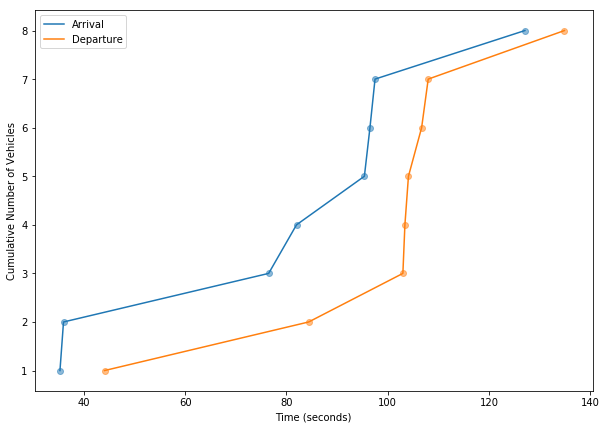

In [54]:
# Ask for cycle number
C = int(input('Enter Cycle Number: '))

# Calculate cycle delay and plot the curves
def Cycle_arrival_departure_curve():
    df1_a = df1.where((df1['Cycle']==C) & (df1['Event_parameter']==4)).dropna() # Slice df for arrivals in the cycle of interest
    df1_a.index = np.arange(1,len(df1_a)+1) # Change the index to show the cumulative number of arrivals for the cycle
    df1_d = df1.where((df1['Cycle']==C) & (df1['Event_parameter']==41) |
                    (df1['Cycle']==C) & (df1['Event_parameter']==42) |
                    (df1['Cycle']==C) & (df1['Event_parameter']==43)).dropna() # Slice df for dep. in the cycle of interest
    df1_d.index = np.arange(1, len(df1_d)+1) # Change the index to show the cumulative number of dep. for the cycle

    # Calculate the cycle delay and average delay per vehicle assuming FIFO 
    d = df1_d['Sec']-df1_a['Sec']
    C_delay = sum(i for i in d if i > 0)
    Avg_delay = C_delay/len(d)
    print('Cycle delay in seconds: ', C_delay)
    print('Per vehicle delay in seconds: ', Avg_delay)

    # Plot the cumulative arrival-departure curves for the cycle
    plt.figure(figsize=(10,7))
    plt.scatter(df1_a['Sec'], df1_a.index, alpha=0.5)
    plt.plot(df1_a['Sec'], df1_a.index, label='Arrival')
    plt.scatter(df1_d['Sec'], df1_d.index, alpha=0.5)
    plt.plot(df1_d['Sec'], df1_d.index, label='Departure')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Cumulative Number of Vehicles')
    plt.legend()
    plt.show()

Cycle_arrival_departure_curve()

## Creating cycle-based delay charts for the entire day

In [55]:
CL =  df1['Cycle'].unique().astype(int)
C_D = []
Avg_C_D = []

for C in CL:
    df1_a = df1.where((df1['Cycle']==C) & (df1['Event_parameter']==4)).dropna() # Slice df for arrivals in the cycle of interest
    df1_a.index = np.arange(1,len(df1_a)+1) # Change the index to show the cumulative number of arrivals for the cycle
    df1_d = df1.where((df1['Cycle']==C) & (df1['Event_parameter']==41) |
                    (df1['Cycle']==C) & (df1['Event_parameter']==42) |
                    (df1['Cycle']==C) & (df1['Event_parameter']==43)).dropna() # Slice df for dep. in the cycle of interest
    df1_d.index = np.arange(1, len(df1_d)+1) # Change the index to show the cumulative number of dep. for the cycle

    # Calculate the cycle delay and average delay per vehicle assuming FIFO 
    d = df1_d['Sec']-df1_a['Sec']
    C_delay = sum(i for i in d if i > 0)
    Avg_delay = C_delay/len(d)
    #print('Cycle delay in seconds: ', C_delay)
    #print('Per vehicle delay in seconds: ', Avg_delay)
    C_D.append(C_delay)
    Avg_C_D.append(Avg_delay)

In [56]:
CbyC_delay = pd.DataFrame({'Cycle':CL,
                          'D/C': C_D,
                          'AvgD/C': Avg_C_D})

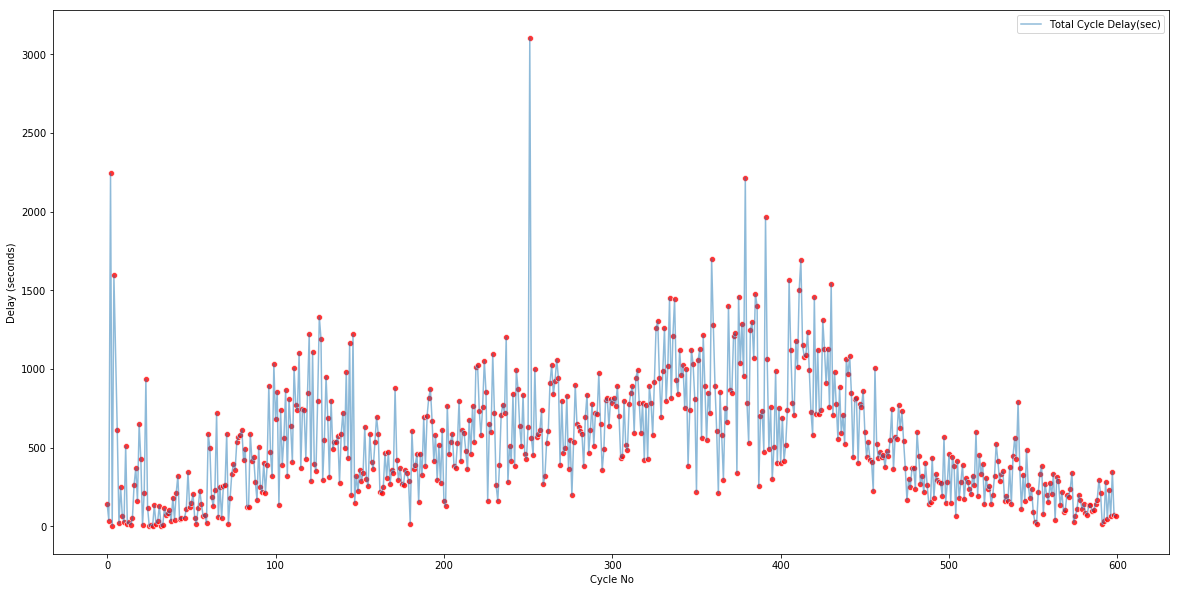

In [57]:
# Plot total cycle delay for the entire day
plt.figure(figsize = (20,10))
sns.lineplot(CbyC_delay['Cycle'],
             CbyC_delay['D/C'], alpha = 0.5, label = 'Total Cycle Delay(sec)' )
sns.scatterplot(CbyC_delay['Cycle'],
             CbyC_delay['D/C'], alpha =0.8, color='red' )
plt.xlabel('Cycle No')
plt.ylabel('Delay (seconds)')
plt.legend()
plt.show()

## Delay Calculation Given the start and end of the analysis period

In [58]:
# Create a df that gives delay for each actuation of the upstream detector 
df_arrivals = df1.where(df1['Event_parameter']==4).dropna() 
df_arrivals = df_arrivals[['ID', 'Datetime', 'Event_code', 'Event_parameter', 'hr', 'Cycle', 'Sec']]
df_arrivals = df_arrivals.reset_index()

df_deps = df1.where((df1['Event_parameter']==41) |
                    (df1['Event_parameter']==42) |
                   (df1['Event_parameter']==43)).dropna() 
df_deps = df_deps[['ID', 'Datetime', 'Event_code', 'Event_parameter', 'hr', 'Cycle', 'Sec']]
df_deps = df_deps.reset_index()

df3 = df_arrivals.copy()
df3['D_time(sec)'] = df_deps['Sec']
df3['Delay'] = (df3['D_time(sec)'] - df3['Sec']).clip(lower=0) # get the delay and set negative values equal to zero
df3 = df3.rename(columns={'Sec':'A_time(sec)'})


### Delay for a selected period

In [59]:
St = int(input('Enter the start of analysis period (seconds from midnight): '))
End = int(input('Enter the end of analysis period (seconds from midnight): '))

def total_and_average_delay():
    TD = df3['Delay'].where((df3['A_time(sec)']>=St) & (df3['D_time(sec)']<=End)).dropna().sum()
    AD = TD/((df3['Delay'].where((df3['A_time(sec)']>=St) & (df3['D_time(sec)']<=End)).dropna()).count())
    print('Total Delay for Selected Period: {:0.2f} hours' .format(TD/3600))
    print('Average Delay for the Selected Period: {:0.2f} seconds/veh '.format(AD))
total_and_average_delay()

Enter the start of analysis period (seconds from midnight): 0
Enter the end of analysis period (seconds from midnight): 3600
Total Delay for Selected Period: 1.38 hours
Average Delay for the Selected Period: 38.63 seconds/veh 


### Delay for each cycle

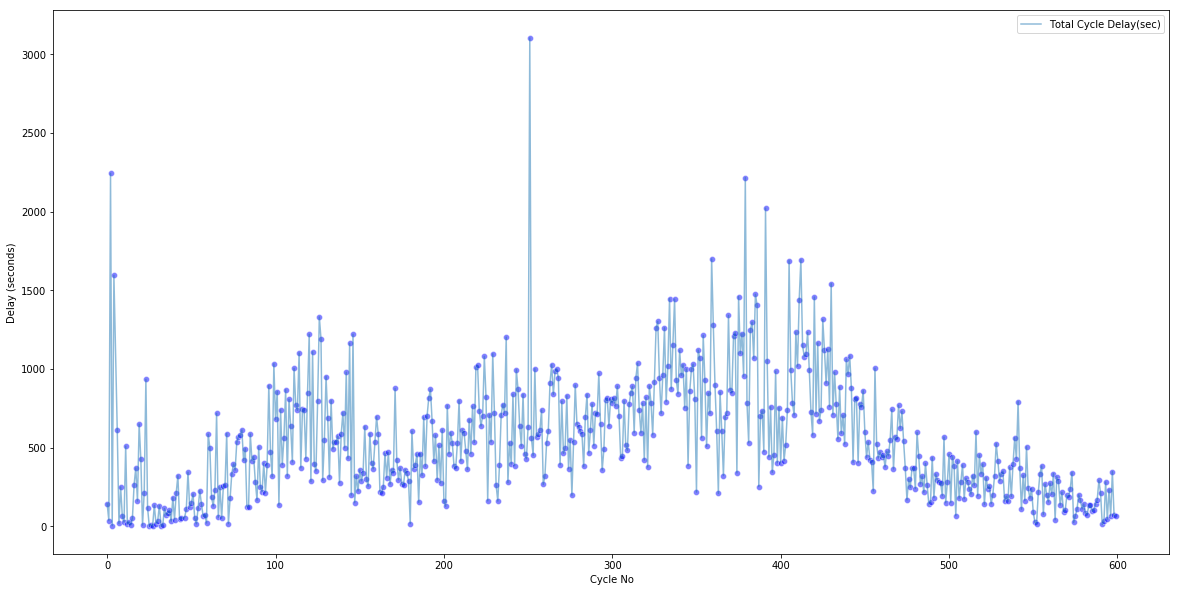

In [60]:
CD_ = df3.groupby('Cycle').sum()
CD__ = df3.groupby('Cycle').mean()
CD_['AvgD/C'] = CD__['Delay']
CD = CD_[['AvgD/C', 'Delay']]
CD = CD.rename(columns={'Delay':'T_Delay/C'})

# plot total delay for each cycle
plt.figure(figsize = (20,10))
sns.lineplot(CD.index,CD['T_Delay/C'], alpha = 0.5, label = 'Total Cycle Delay(sec)' )
sns.scatterplot(CD.index,CD['T_Delay/C'], alpha = 0.5, color='blue' )
plt.xlabel('Cycle No')
plt.ylabel('Delay (seconds)')
plt.legend()
plt.show()

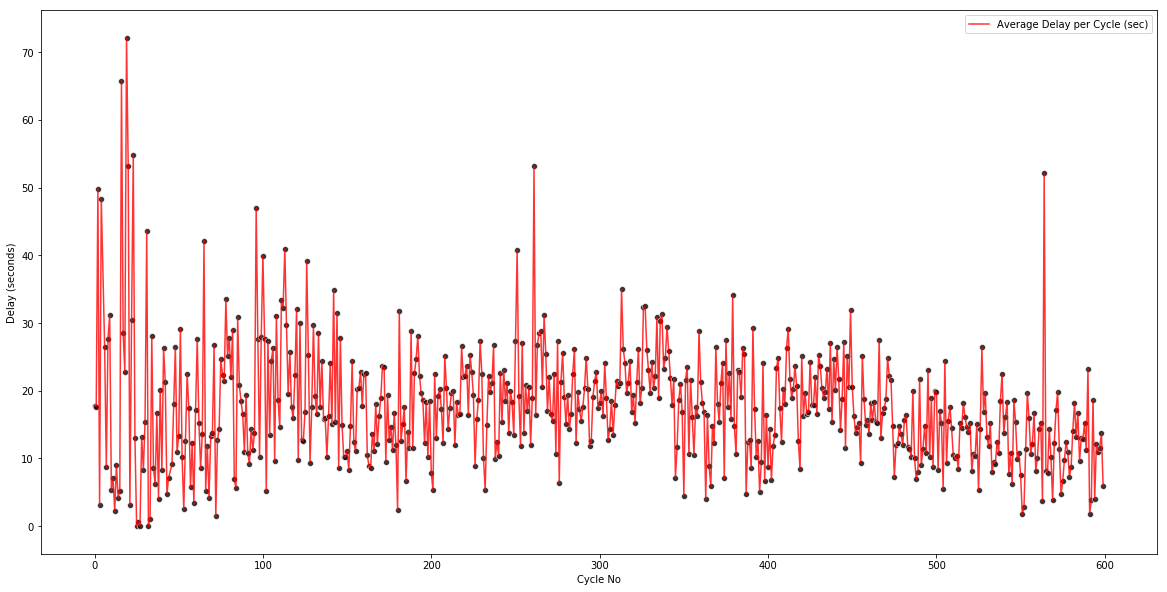

In [61]:
# plot average dela for each cycle
plt.figure(figsize = (20,10))
sns.lineplot(CD.index, CbyC_delay['AvgD/C'], alpha =0.8, color='red', label='Average Delay per Cycle (sec)' )
sns.scatterplot(CD.index, CbyC_delay['AvgD/C'], alpha =0.8, color='black')
plt.xlabel('Cycle No')
plt.ylabel('Delay (seconds)')
plt.legend()
plt.show()

### Five-min average delay

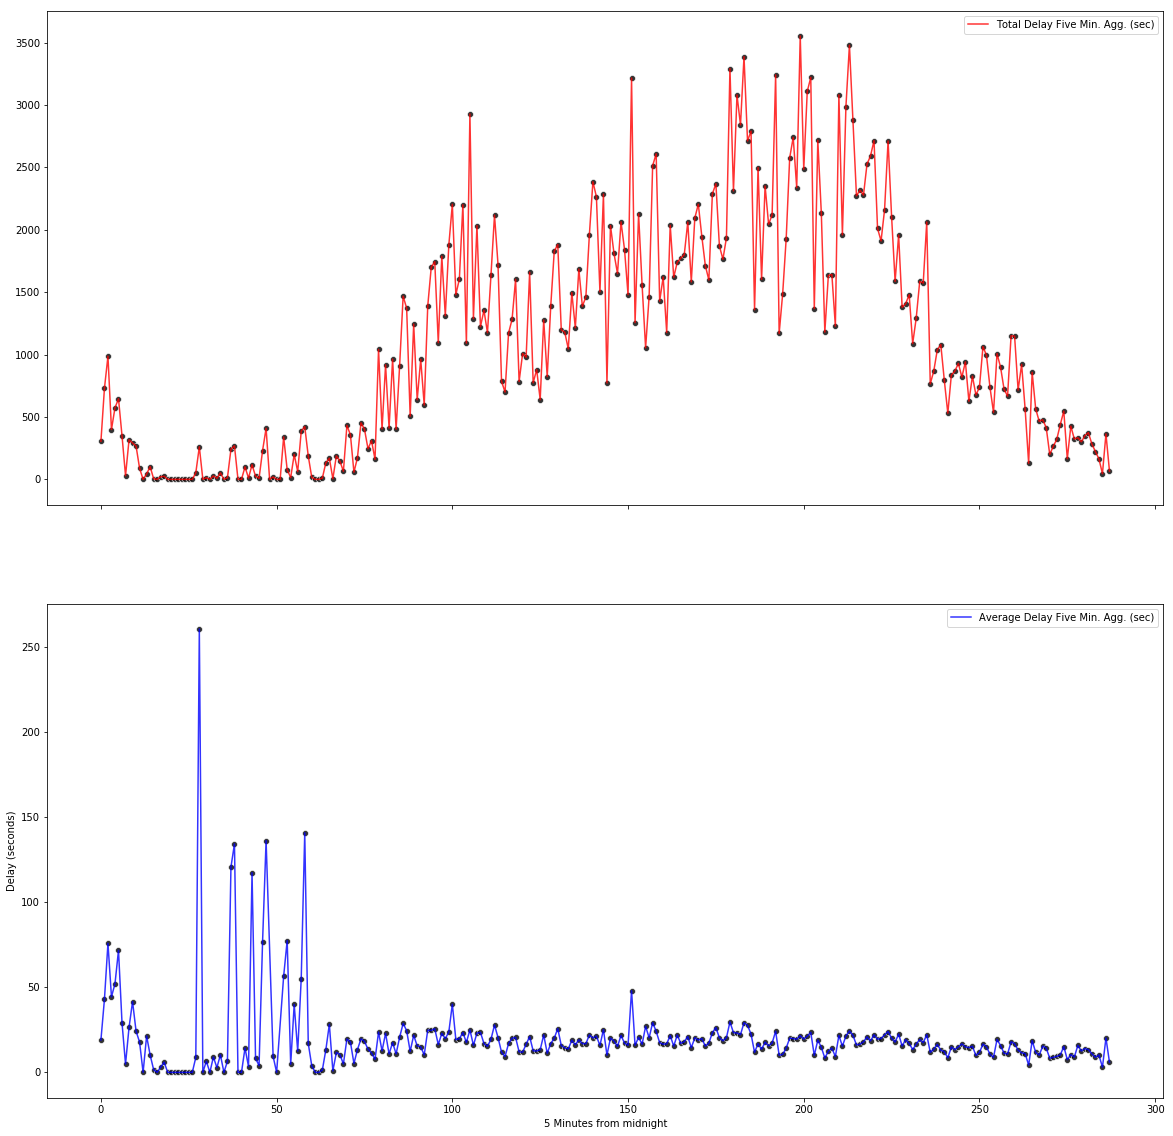

In [62]:
m_5 = np.arange(0,288,1)
AP_5_s = np.arange(0,86400,300)
AP_5_e = np.arange(300,86700,300)

TD_5 = []
AD_5 = []
for x,y in zip(AP_5_s, AP_5_e):
    td = df3['Delay'].where((df3['A_time(sec)']>=x) & (df3['A_time(sec)']<y)).dropna().sum()
    ad = df3['Delay'].where((df3['A_time(sec)']>=x) & (df3['A_time(sec)']<y)).dropna().mean()
    TD_5.append(td)
    AD_5.append(ad)
    
    
fig, ax = plt.subplots(2,1, figsize=(20,20), sharex=True)

sns.lineplot(m_5, TD_5, alpha =0.8, color='red', label='Total Delay Five Min. Agg. (sec)',ax=ax[0] )
sns.scatterplot(m_5, TD_5, alpha =0.8, color='black', ax=ax[0])
sns.lineplot(m_5, AD_5, alpha =0.8, color='blue', label='Average Delay Five Min. Agg. (sec)',ax=ax[1] )
sns.scatterplot(m_5, AD_5, alpha =0.8, color='black', ax=ax[1])
plt.xlabel('5 Minutes from midnight')
plt.ylabel('Delay (seconds)')
plt.legend()
plt.show()

### 15-min average delay

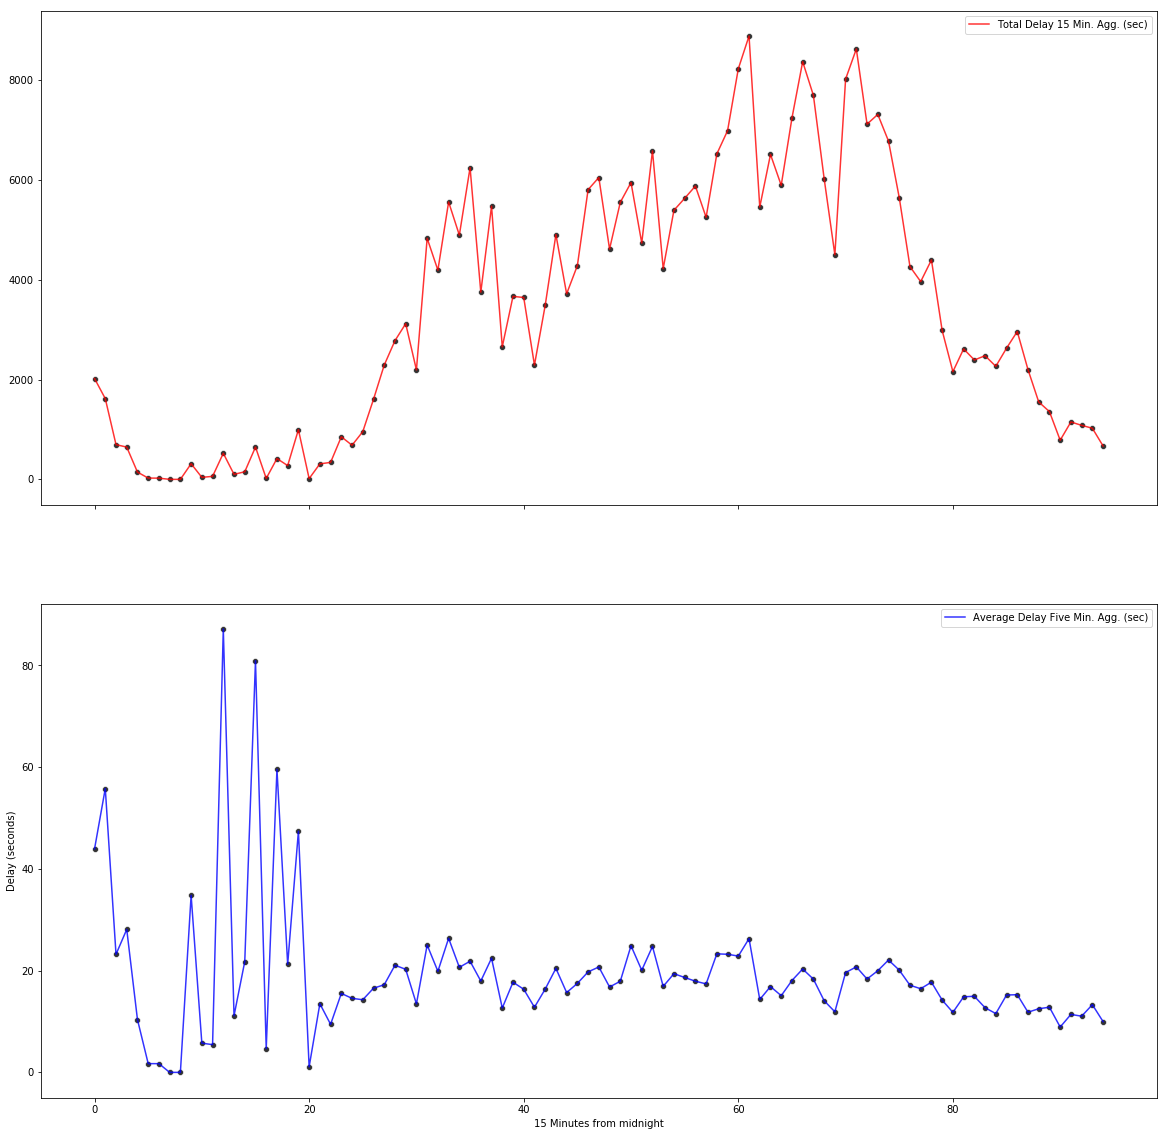

In [63]:
m_15 = np.arange(0,95,1)
AP_15_s = np.arange(0,85500, 900)
AP_15_e = np.arange(900,86400, 900)

TD_15 = []
AD_15 = []
for x,y in zip(AP_15_s, AP_15_e):
    td15 = df3['Delay'].where((df3['A_time(sec)']>=x) & (df3['A_time(sec)']<y)).dropna().sum()
    ad15 = df3['Delay'].where((df3['A_time(sec)']>=x) & (df3['A_time(sec)']<y)).dropna().mean()
    TD_15.append(td15)
    AD_15.append(ad15)

fig, ax = plt.subplots(2,1, figsize=(20,20), sharex=True)

sns.lineplot(m_15, TD_15, alpha =0.8, color='red', label='Total Delay 15 Min. Agg. (sec)',ax=ax[0] )
sns.scatterplot(m_15, TD_15, alpha =0.8, color='black', ax=ax[0])
sns.lineplot(m_15, AD_15, alpha =0.8, color='blue', label='Average Delay Five Min. Agg. (sec)',ax=ax[1] )
sns.scatterplot(m_15, AD_15, alpha =0.8, color='black', ax=ax[1])
plt.xlabel('15 Minutes from midnight')
plt.ylabel('Delay (seconds)')
plt.legend()
plt.show()